# Echo chambers

Find groups of users which often send out the same tweets

In [1]:
import os
import pandas as pd
import re
import sys

from IPython.display import clear_output

## 1. Functions for retrieving user groups from tweets

In [2]:
DATADIR = "../data/text/"
TEXT = "text"
USER = "user"
MIN_TWEET_LENGTH = 10

In [3]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

        
def remove_url_suffix(tweet):
    return(re.sub("\s*https?://.*$","",tweet,flags=re.IGNORECASE))


def remove_rt_prefix(tweet):
    return(re.sub("^RT[^:]*:\s*","",tweet))


def read_tweets(file_pattern):
    file_names = sorted(os.listdir(DATADIR))
    users_per_tweet = {}
    tweets_per_user = {}
    nbr_of_tweets = 0
    for file_name in file_names:
        if re.search(file_pattern,file_name):
            squeal(file_name)
            df = pd.read_csv(DATADIR+file_name)
            nbr_of_tweets += len(df)
            for i in range(0, len(df)):
                user = df.iloc[i]["user"]
                text = remove_rt_prefix(remove_url_suffix(df.iloc[i]["text"])).strip()
                if len(text) >= MIN_TWEET_LENGTH:
                    if text not in users_per_tweet: 
                        users_per_tweet[text] = [user]
                    elif user not in users_per_tweet[text]: 
                        users_per_tweet[text].append(user)
                    if user not in tweets_per_user: 
                        tweets_per_user[user] = 1
                    else: 
                        tweets_per_user[user] += 1
    return users_per_tweet,tweets_per_user,nbr_of_tweets


def read_tweets_of_user_group(file_pattern, user_group, reverse=False):
    file_names = sorted(os.listdir(DATADIR))
    texts = []
    for file_name in file_names:
        if re.search(file_pattern,file_name):
            df = pd.read_csv(DATADIR+file_name)
            if not reverse:
                df = df[df[USER].isin(user_group)]
            else:
                df = df[~df[USER].isin(user_group)]
            texts.extend(list(df[TEXT]))
            squeal(file_name)
    return texts

In [4]:
def get_user_pairs(users_per_tweet):
    user_pairs = {}
    for user_group in users_per_tweet.values():
        for i in range(1,len(user_group)):
            for j in range(i+1,len(user_group)):
                pair = " ".join([user_group[i],user_group[j]])
                if not pair in user_pairs: user_pairs[pair] = 1
                else: user_pairs[pair] += 1
    return(user_pairs)

In [5]:
def show_top_user_pairs(user_pairs):
    for pair in sorted(user_pairs.keys(),key=lambda p:user_pairs[p],reverse=True)[:20]:
        print(f"{user_pairs[pair]} {pair}")
    return()

In [6]:
THRESHOLD = 10

def make_user_groups(user_pairs):
    user_groups = {}
    for pair in user_pairs:
        if user_pairs[pair] >= THRESHOLD:
            user1,user2 = pair.split()
            if not user1 in user_groups and not user2 in user_groups:
                user_groups[user1] = (user1,user2)
                user_groups[user2] = (user1,user2)
            elif user1 in user_groups and not user2 in user_groups:
                user_groups[user1] = tuple(set(user_groups[user1]+(user2,)))
                for e in user_groups[user1]: user_groups[e] = user_groups[user1]
                user_groups[user2] = user_groups[user1]
            elif not user1 in user_groups and user2 in user_groups:
                user_groups[user2] = tuple(set(user_groups[user2]+(user1,)))
                for e in user_groups[user2]: user_groups[e] = user_groups[user2]
                user_groups[user1] = user_groups[user2]
            else:
                user_groups[user1] = tuple(set(user_groups[user1]+user_groups[user2]))
                for e in user_groups[user1]: user_groups[e] = user_groups[user1]
                for e in user_groups[user2]: user_groups[e] = user_groups[user1]
    return(user_groups)

In [7]:
MIN_USER_GROUP_SIZE = 5

def show_user_groups(user_groups, group_size_show=10):
    seen = {}
    first_user = ""
    for user in sorted(user_groups.keys(), key=lambda u: len(user_groups[u]), reverse=True):
        if not user in seen and len(user_groups[user]) >= MIN_USER_GROUP_SIZE:
            if first_user == "":
                first_user = user
            print(len(user_groups[user]), [u for u in sorted(user_groups[user],key=lambda u:u.lower())][:group_size_show])
            for u in user_groups[user]: 
                seen[u] = True
    return first_user

In [8]:
def get_largest_group(user_groups):
    largest_group = []
    for user in user_groups:
        if len(user_groups[user]) > len(largest_group): 
            largest_group = user_groups[user]
    return(largest_group)

def compute_overlap(group1,group2):
    return(len(set(group1) & set(group2)))

def get_nbr_of_tweets(user_group,tweets_per_user):
    nbr_of_tweets = 0
    for user in user_group: nbr_of_tweets += tweets_per_user[user]
    return(nbr_of_tweets)

In [9]:
LOGFILE = "echo-chambers.csv"

def write_log(line):
    logfile = open(LOGFILE, "a")
    print(line, file=logfile)
    logfile.close()

In [10]:
def process_day(date, previous_largest_user_group=[], last_seen={}):
    users_per_tweet, tweets_per_user, nbr_of_tweets = read_tweets(date)
    if nbr_of_tweets == 0: 
        return ...
    user_pairs = get_user_pairs(users_per_tweet)
    user_groups = make_user_groups(user_pairs)
    largest_user_group = get_largest_group(user_groups)
    largest_user_group_tweet_count = get_nbr_of_tweets(largest_user_group,tweets_per_user)
    if len(previous_largest_user_group) == 0:
        overlap_count = 0
    else:
        overlap_count = compute_overlap(previous_largest_user_group,largest_user_group)
    print(f"date: {date}; largest group size: {len(largest_user_group)}; overlap with previous day: {overlap_count};",
          f"tweets group: {largest_user_group_tweet_count}; all tweets: {nbr_of_tweets}; member: {largest_user_group[0]}")
    write_log(f"{date},{len(largest_user_group)},{overlap_count},{largest_user_group_tweet_count},{nbr_of_tweets},{largest_user_group[0]}")
    for user in largest_user_group: 
        last_seen[user] = date
    return user_groups, largest_user_group, last_seen, user_pairs

## 2. Functions for drawing wordclouds

In [11]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer

In [12]:
def show_wordcloud(term_frequencies):
    plt.figure(figsize=(30, 30))
    plt.imshow(term_frequencies, interpolation="bilinear")
    plt.axis("off")
    plt.savefig("wordcloud.png")
    plt.show()

In [13]:
stopwords = ("aan aangezien absoluut achter af afgelopen al algemeen alle alleen allemaal allen alles als alsnog alsof altijd ander andere anders "
"antwoord april art augustus basis beeld beetje begin beginnen begint begrijp behalve beide bekend belangrijk ben benieuwd bent bepaalde "
"beperkt best beste betekent beter betreft bezig bij bijna bijv bijvoorbeeld blijf blijft blijkbaar blijkt blijven boven bovendien brengen buiten buurt "
"buurten compleet daadwerkelijk daar daarbij daardoor daarmee daarna daarnaast daarom daarvan daarvoor dacht dag dagen dan dat de december deel denk "
"denken denkt deze dezelfde die dingen direct dit doe doen doet door doordat drie duidelijk dus duurt echt echte echter edit een eens eerder eerlijk eerst "
"eerste eigen eigenlijk eind eindelijk elk elkaar elke en ene enige enkel enkele enorm er erg ergens erger ervan ervoor etc even extra februari fijn flink fout "
"ga gaan gaat gebeuren gebeurt gebruik gebruiken gebruikt gedaan geef geeft geen gegaan gegeven gehad gehouden gek geldt geleden gelijk gelukkig gemaakt genoeg genomen geval "
"geven gevoel gevolgen geweest gewoon geworden gezegd gezien ging gisteren goed goede gooi gooien graag groep groot grootste  grote groter haar had hadden halen half hard heb hebben "
"hebt heeft heel heen helaas hele helemaal helpt hem hen het hetzelfde hier hij hoe hoeft hoeveel hoeveelheid hoeven hoger hoog hoop hoor hopelijk hopen horen hou houd houden "
"houdt https huidige hun idee ieder iedere iedereen iemand iets ik in inderdaad ineens informatie ingevoerd inmiddels ipv is ivm ja januari jaren je jezelf jij jonge "
"jou jouw juist juli jullie juni kan kans kant keer kijk kijken klaar klein kleine klinkt klopt kom komen komende komt kon kreeg krijg krijgen krijgt kun kunnen "
"kunt kwam laag laat laatste land landen lang lange langer langs last lastig laten later leer lees lekker letterlijk leven lezen liever liggen ligt lijken lijkt "
"logisch loopt lopen los m'n maak maakt maand maar maart mag maken makkelijk makkelijker man manier me mee meer meerdere meest meeste mei men mensen met "
"meteen middel mij mijn minder misschien mocht moeilijk moest moet moeten mogelijk mogen moment momenteel morgen na naar naast namelijk "
"natuurlijk nauwelijk nauwelijks nederland nederlander nederlanders nederlandse nee neem neemt nemen nergens net niemand niet niets nieuw nieuwe niks nl no "
"nodig nog nogal nooit normaal normale nou november nu of ofzo oktober om omdat on ondanks onder ondertussen ongeveer ons onze ooit ook op openlijk open over overal "
"overigens pa paar pakken pas per persoonlijk plek plekken praten precies prima probeer proberen punt qua raken redelijk relatief rest roepen rond rt samen september serieus simpelweg "
"sinds slechts snap snel sneller som sommige soms soort sowieso staan staat steed steeds stel stellen sterk strak straks stuk te tegen ten terecht terug "
"terwijl teveel the tijd tijden tijdens to toch toe toen tot totaal trouwens tussen twee u uit uiteindelijk uiteraard uur uw vaak vaker vallen valt van vanaf vandaag vanuit vanwege "
"vast vd veel velen ver verder verhaal verkeerd verplicht verschil verschillende vertrouwen vervolgens verwacht verwachten via vind vinden vindt voelt vol "
"voldoende volgen volgende volgens volledig vond voor vooral voorbij voordat voorkomen vorige vraag vrij vrijdag vrijwel vroeg vs waar waarbij waardoor waarin waarom "
"waarschijnlijk waarvan wachten wanneer want waren was wat we week weer weet weg weinig wel welke wellicht werd werden werken werkt weten wie wij wil willen "
"wilt woord word worden wordt x200b z'n zag zal zat ze zeer zeg zeggen zegt zei zeker zelf zelfs zetten zich zichzelf zie zien ziet zij zijn zin zit zitten zo zo'n "
"zoal zoals zodat zodra zoeken zolang zonder zorgen zorgt zou zouden zoveel zover zowel zullen zwaar één"
)

In [14]:
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white", width=600, height=300, collocations=False, normalize_plurals=False, relative_scaling=1, regexp=r"\w[\w']+",
                      stopwords=(stopwords).split())

In [15]:
NBR_OF_TOKENS = 200

def make_wordcloud(posts, nbr_of_tokens=NBR_OF_TOKENS):
    text = " ".join(posts)
    text = re.sub(r'\\n', ' ', text)
    token_freqs = Counter(tokenize(text.lower()).split())
    top = [(t,token_freqs[t]) for t in sorted(token_freqs.keys(),key=lambda t:token_freqs[t], reverse=True) 
                              if t not in stopwords.split() and re.search("[a-z]", t) and len(t) > 1]
    show_wordcloud(wordcloud.generate_from_frequencies(dict(top[:NBR_OF_TOKENS])))
    return top

In [16]:
def get_position(top, token_filter):
    for i in range(0, len(top)):
        if re.search(token_filter, top[i][0]):
            print(f"{i+1}. {top[i][1]} {top[i][0]}")

In [17]:
def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))

In [18]:
def get_posts(query, date_pattern):
    file_names = sorted(os.listdir(DATADIR))
    selected_file_names = [file_name for file_name in file_names if re.search(date_pattern, file_name) ]
    posts = []
    for file_name in selected_file_names:
        df = pd.read_csv(DATADIR + file_name, index_col=IDSTR)
        posts.extend(list(df[df[TEXT].str.contains(query, flags=re.IGNORECASE)].loc[:,TEXT]))
    return posts

## 3. Processing a single date

In [20]:
DATE = "20191218"

user_groups, _, _, _  = process_day(DATE)

20191218-15.out.gz


KeyboardInterrupt: 

In [ ]:
first_user = show_user_groups(user_groups, group_size_show=1)

20191218-23.out.gz


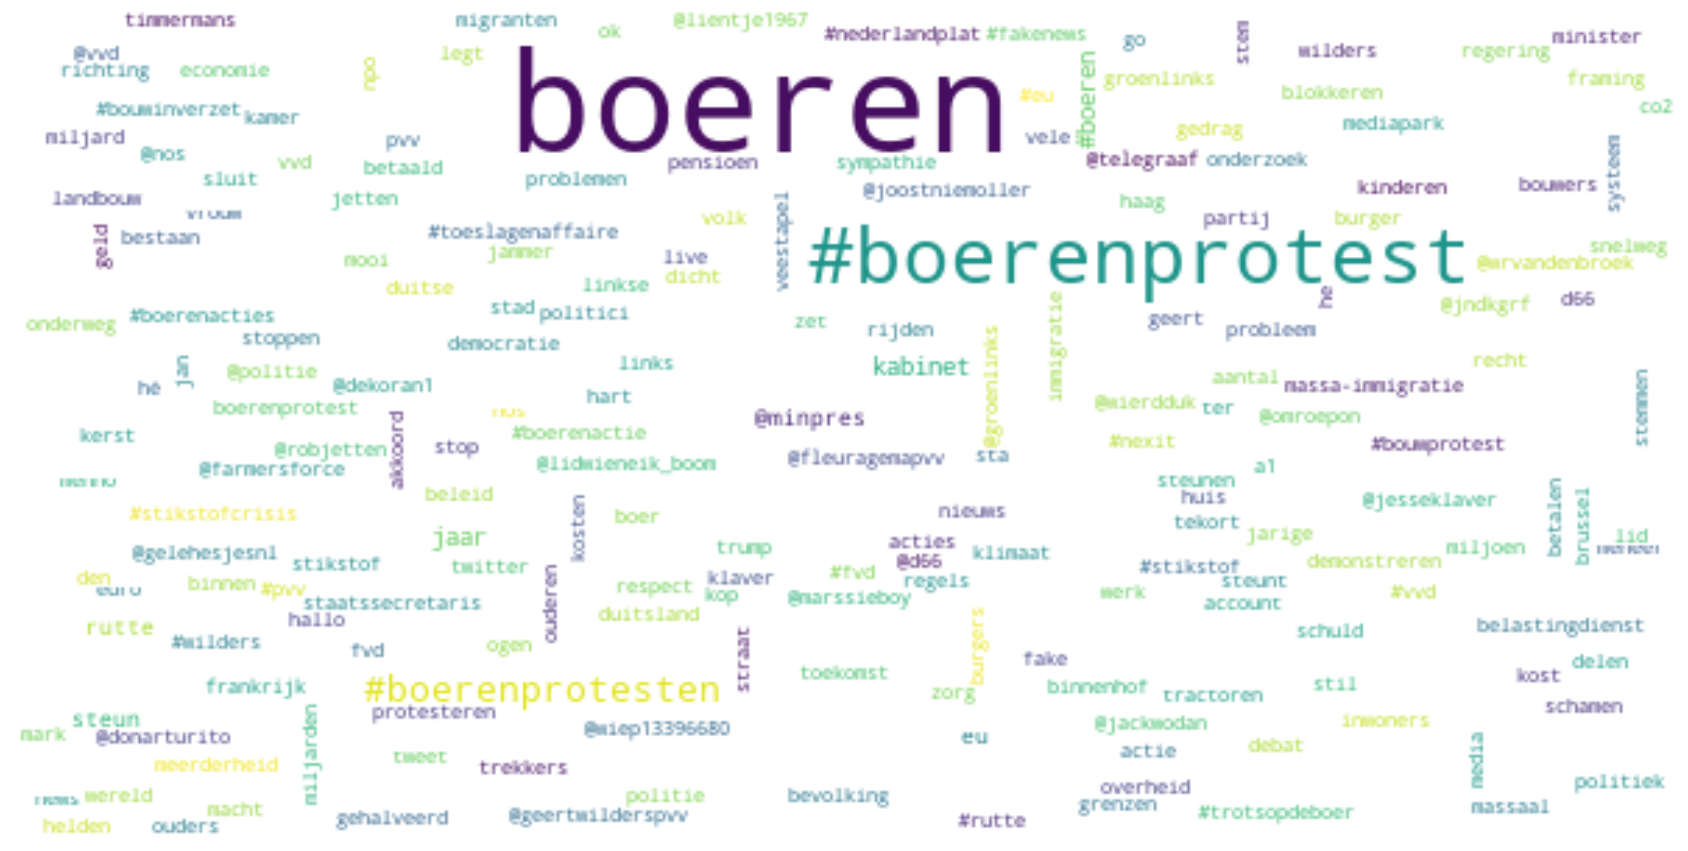

In [32]:
USER_GROUP = user_groups[first_user]

texts = read_tweets_of_user_group(DATE, USER_GROUP)
top_group = make_wordcloud(texts)

20191218-23.out.gz


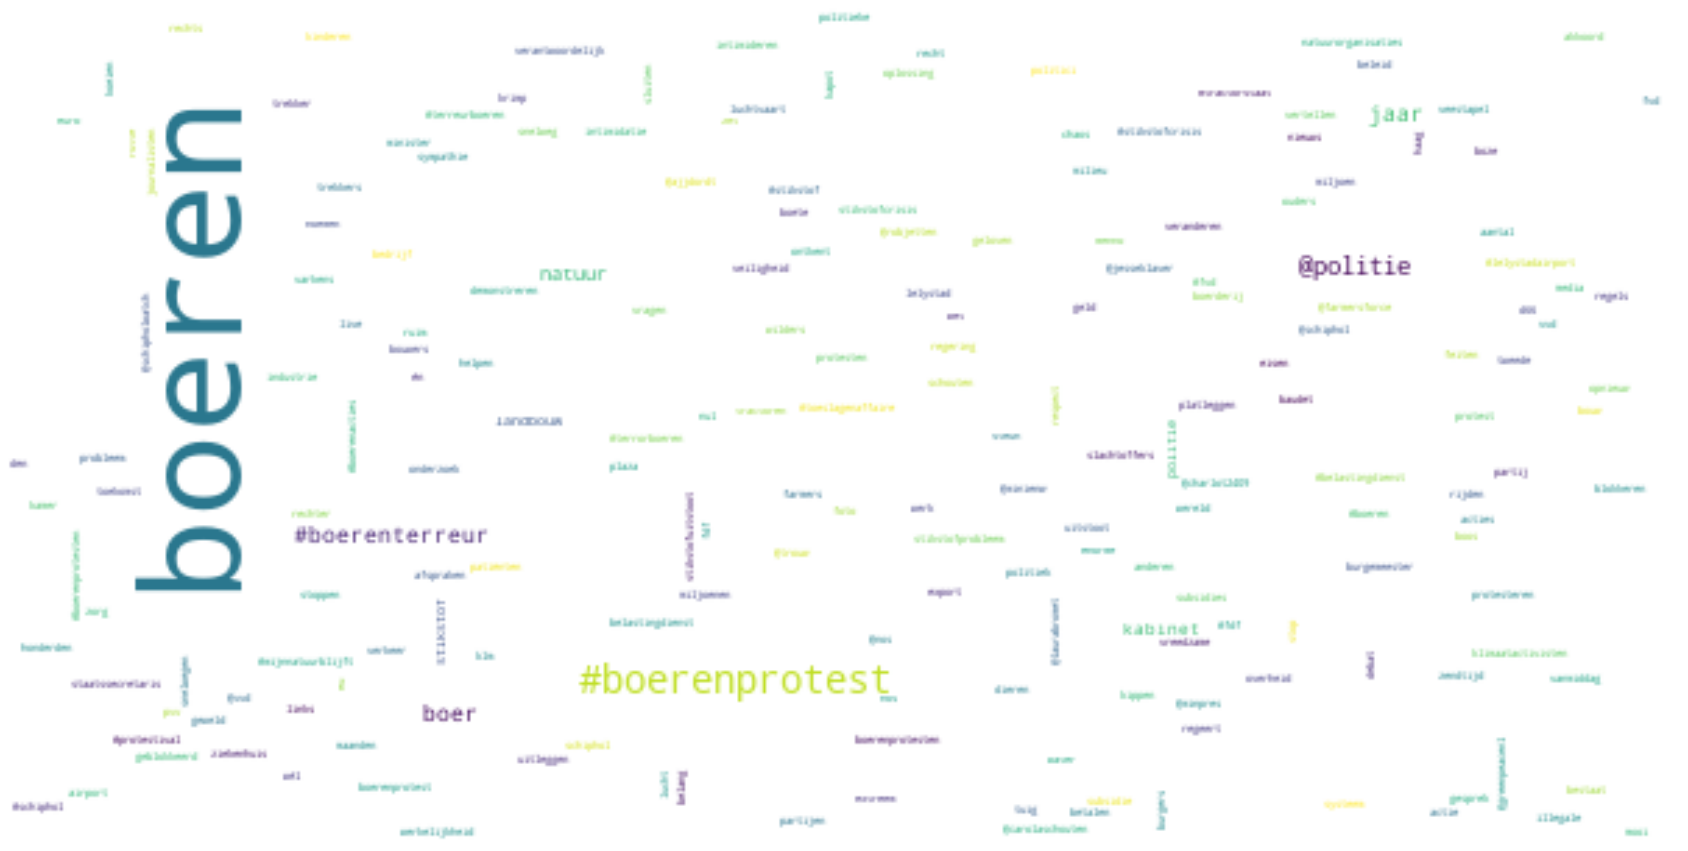

In [42]:
USER_GROUP = user_groups['197winstonsmith']

texts = read_tweets_of_user_group(DATE, USER_GROUP)
top_group2 = make_wordcloud(texts)

20191218-23.out.gz


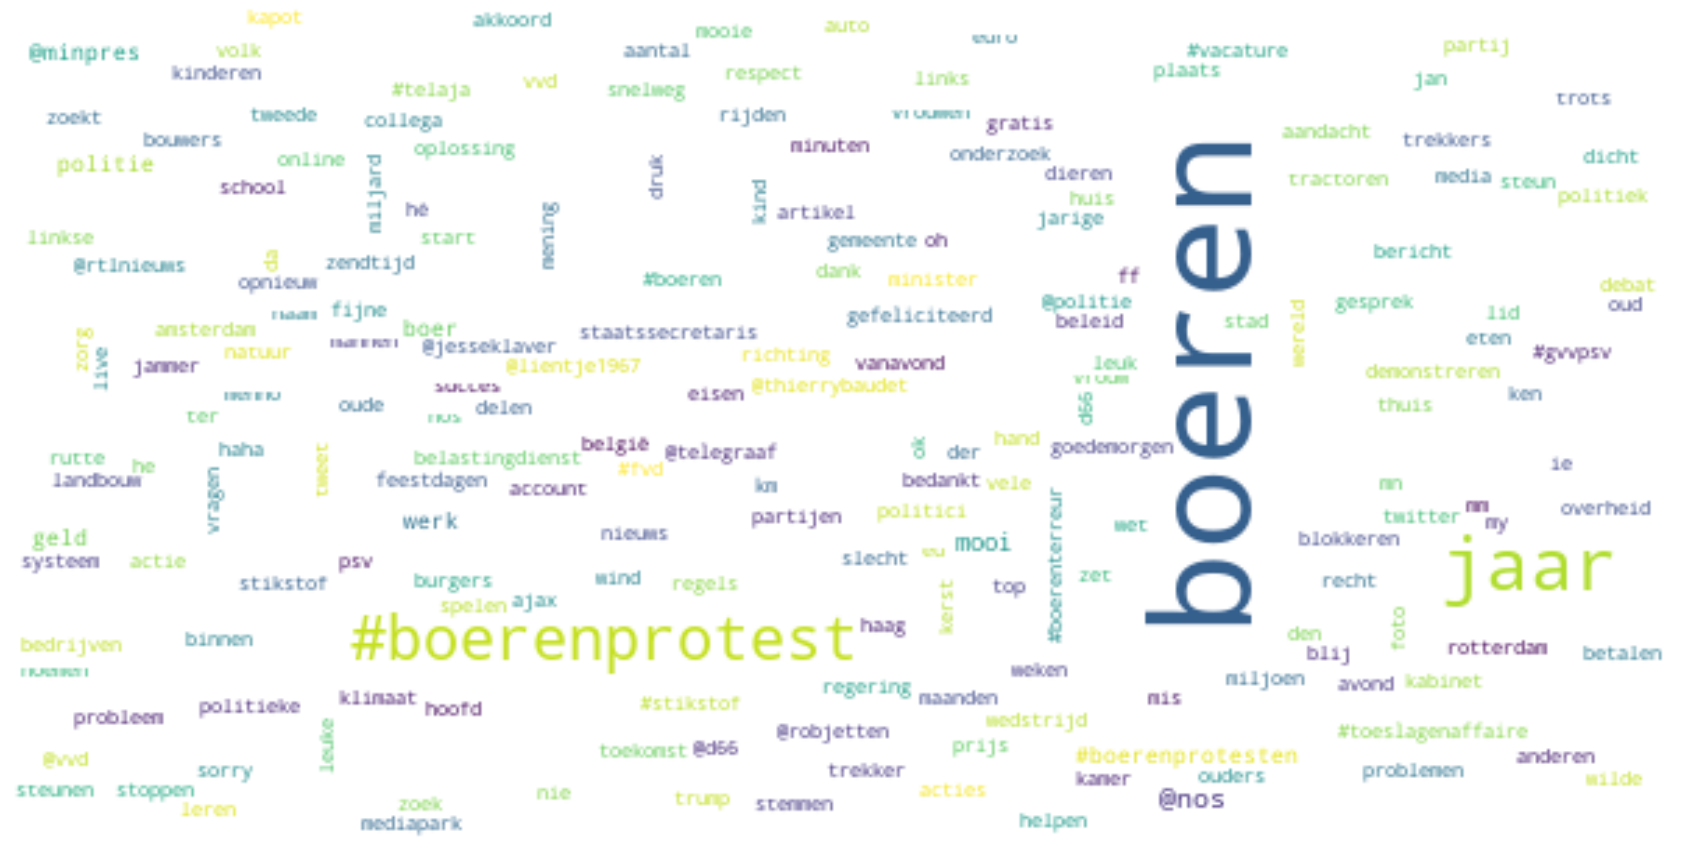

In [48]:
texts = read_tweets_of_user_group(DATE, user_groups[first_user] + user_groups['197winstonsmith'], reverse=True)
top_not_group = make_wordcloud(texts)

20191218-23.out.gz


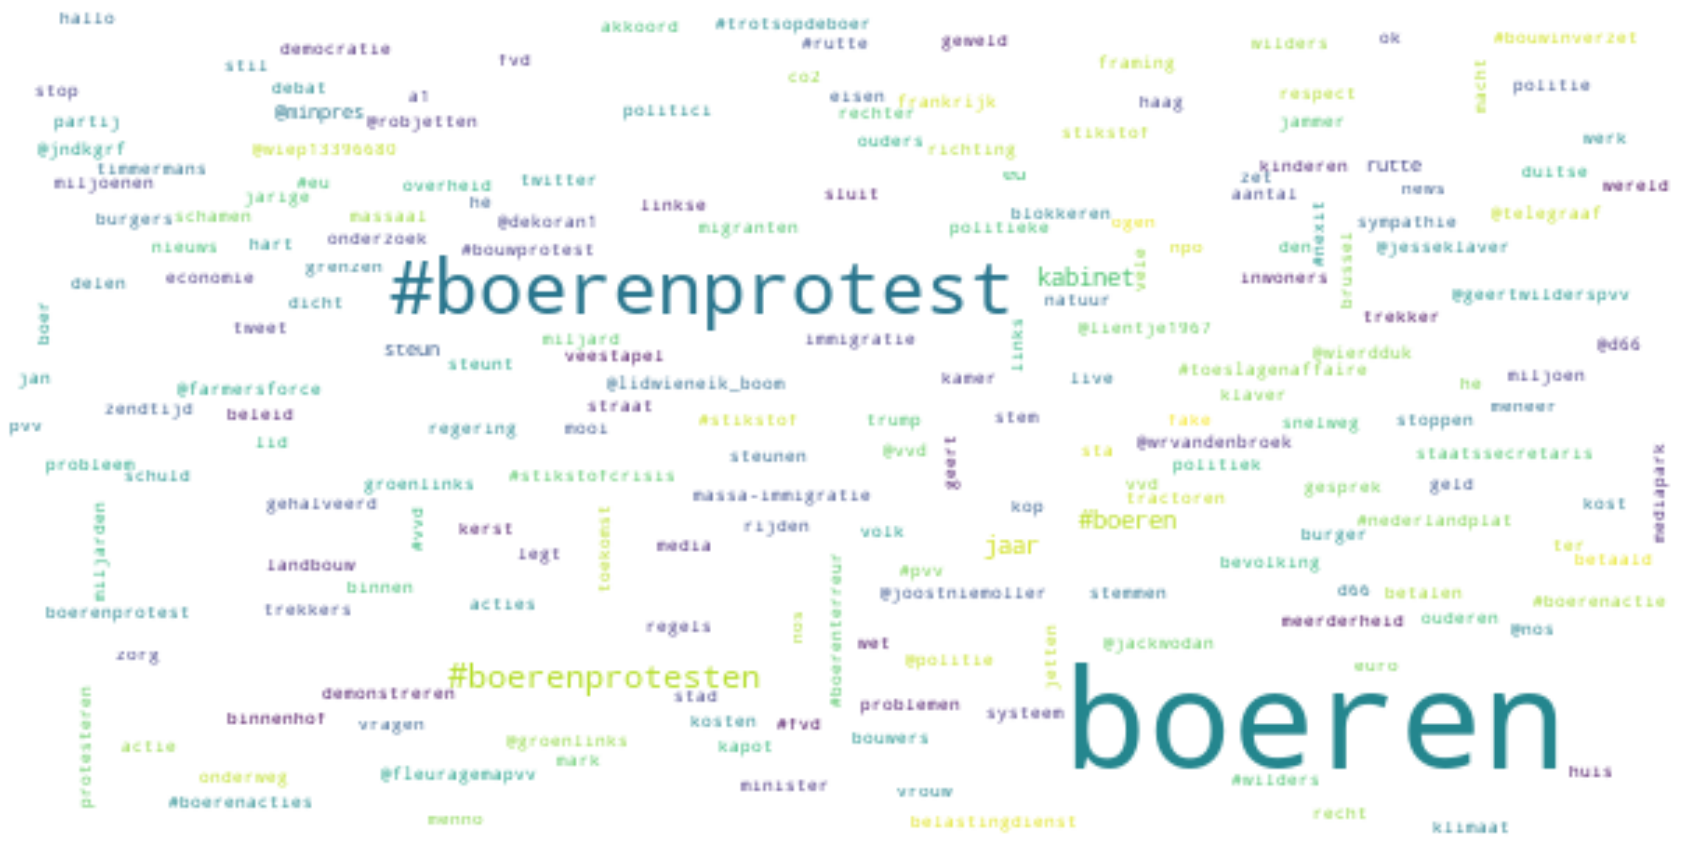

In [49]:
texts = read_tweets_of_user_group(DATE, user_groups[first_user] + user_groups['197winstonsmith'])
top_not_group_neg = make_wordcloud(texts)

In [30]:
TERM = ""
for i in range(0, len(top_not_group)):
    if top_not_group[i][0] == TERM:
        print(i)

142


## 4. t-scores

In [34]:
sys.path.append("/home/erikt/projects/newsgac/fasttext-runs")
import tscore

In [35]:
tscores = tscore.computeTscore({ "totalFreq": sum([ x[1] for x in top_group ]), 
                                 "nbrOfWords": len(top_group),
                                 "wordFreqs": { x[0]: x[1] for x in top_group }}, 
                               { "totalFreq": sum([ x[1] for x in top_not_group ]), 
                                 "nbrOfWords": len(top_not_group),
                                 "wordFreqs": { x[0]: x[1] for x in top_not_group }})

In [36]:
tscores = [ (word, tscores[word]) for word in sorted(tscores.keys(), key=lambda x: tscores[x], reverse=True) if not re.search("^http", word) ]

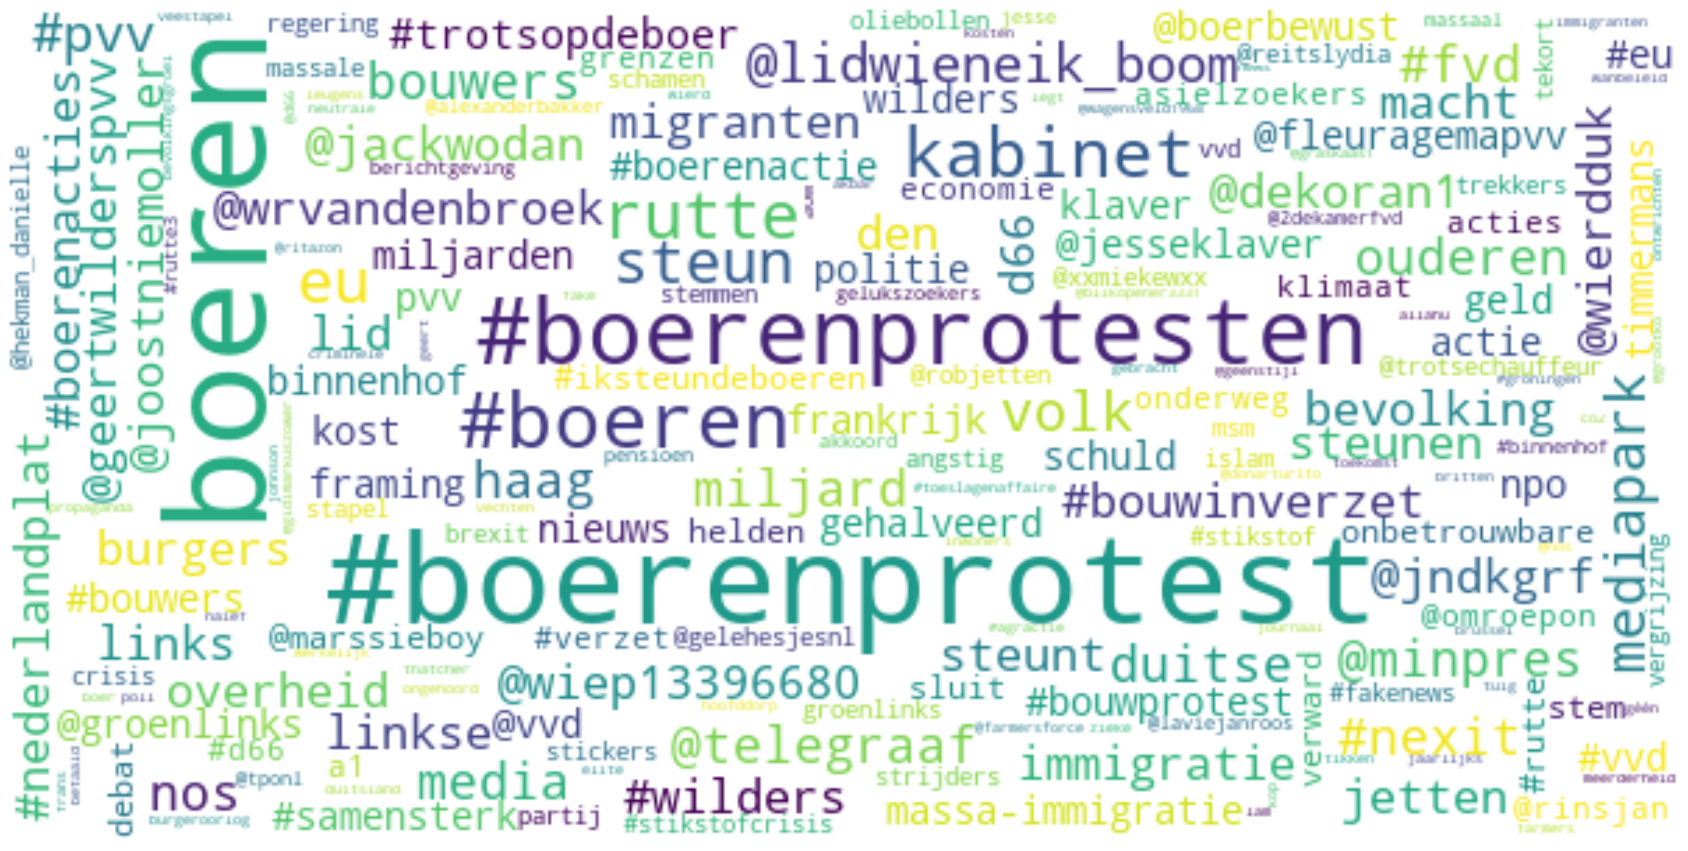

In [37]:
show_wordcloud(wordcloud.generate_from_frequencies(dict(tscores[:NBR_OF_TOKENS])))

In [43]:
tscores = tscore.computeTscore({ "totalFreq": sum([ x[1] for x in top_group2 ]), 
                                 "nbrOfWords": len(top_group2),
                                 "wordFreqs": { x[0]: x[1] for x in top_group2 }}, 
                               { "totalFreq": sum([ x[1] for x in top_group ]), 
                                 "nbrOfWords": len(top_group),
                                 "wordFreqs": { x[0]: x[1] for x in top_group }})

In [44]:
tscores = [ (word, tscores[word]) for word in sorted(tscores.keys(), key=lambda x: tscores[x], reverse=True) if not re.search("^http", word) ]

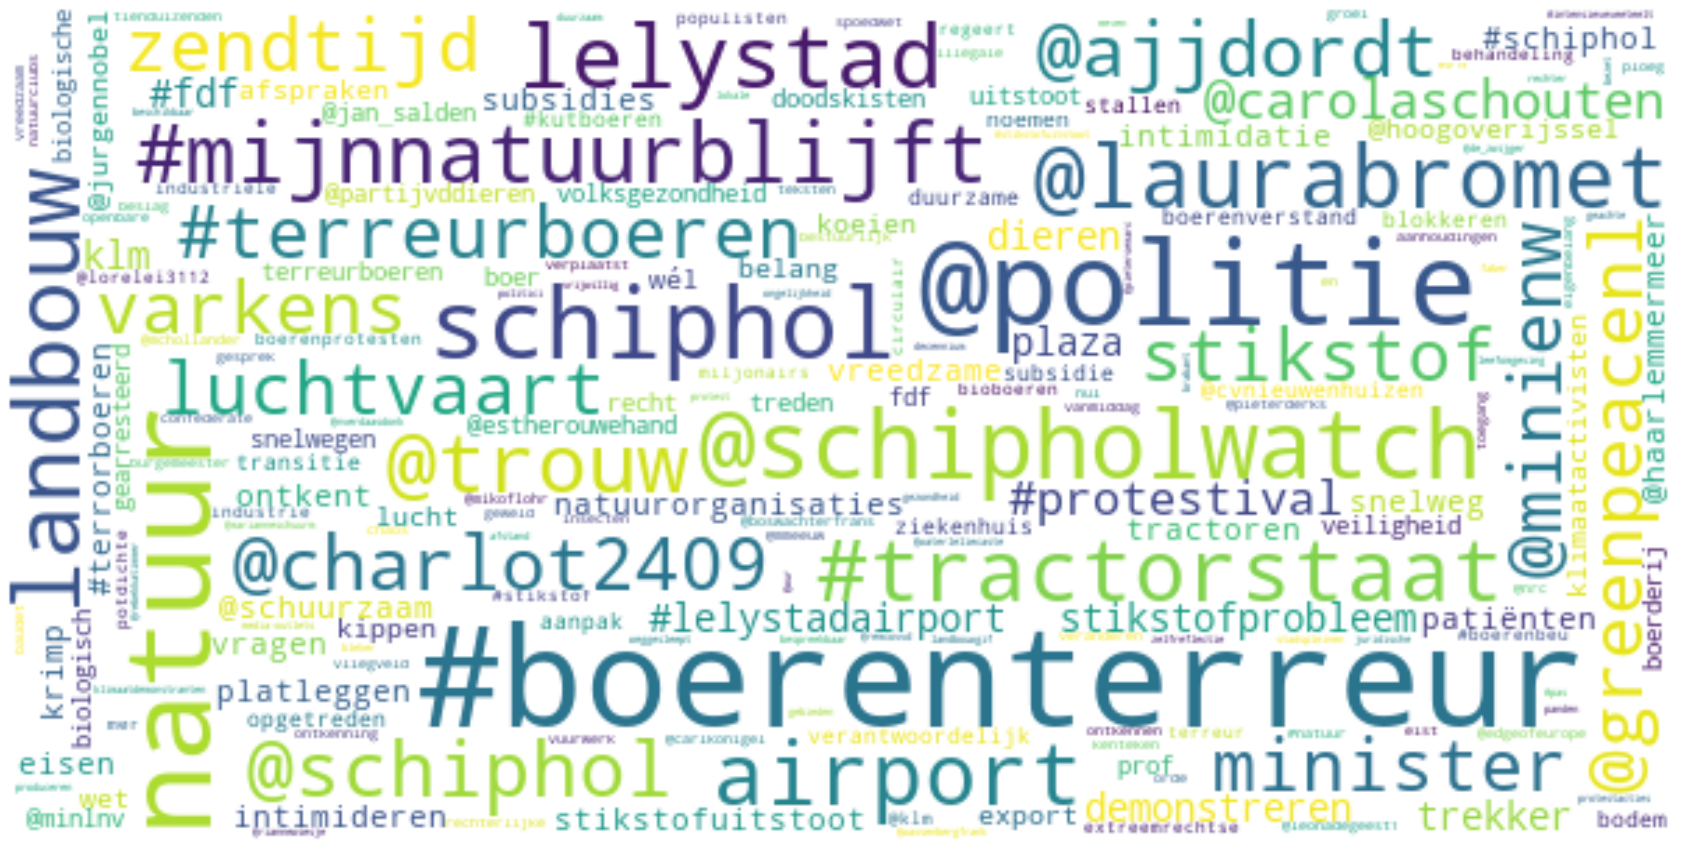

In [45]:
show_wordcloud(wordcloud.generate_from_frequencies(dict(tscores[:NBR_OF_TOKENS])))

In [38]:
tscores = tscore.computeTscore( { "totalFreq": sum([ x[1] for x in top_not_group ]), 
                                 "nbrOfWords": len(top_not_group),
                                 "wordFreqs": { x[0]: x[1] for x in top_not_group }},
                               { "totalFreq": sum([ x[1] for x in top_group ]), 
                                 "nbrOfWords": len(top_group),
                                 "wordFreqs": { x[0]: x[1] for x in top_group }})

In [39]:
tscores = [ (word, tscores[word]) for word in sorted(tscores.keys(), key=lambda x: tscores[x], reverse=True) if not re.search("^http", word) ]

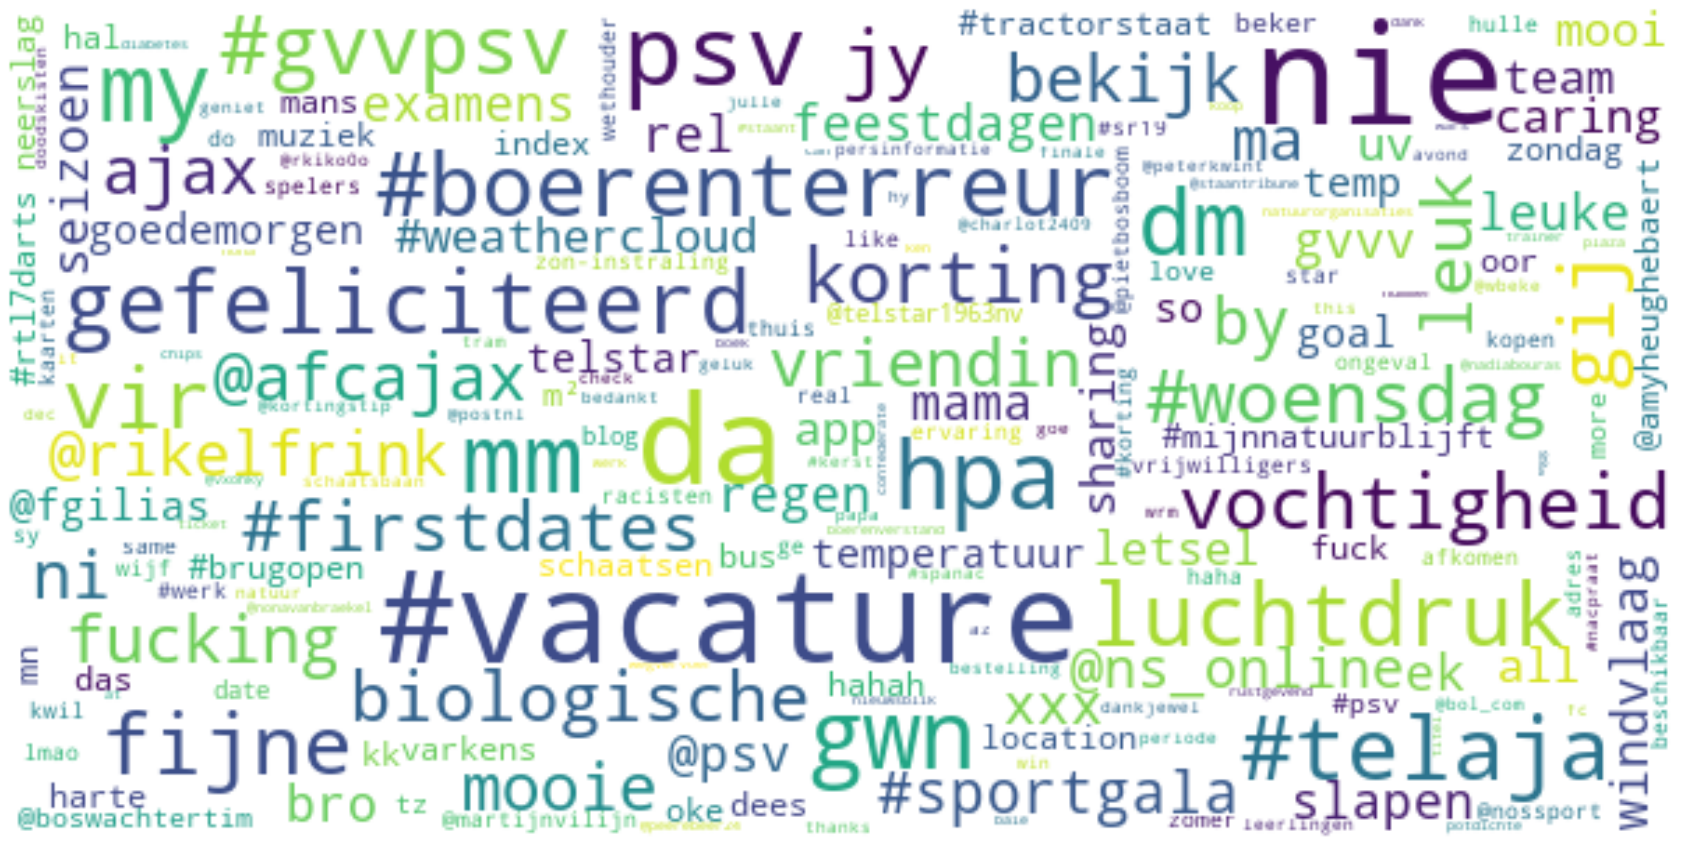

In [40]:
show_wordcloud(wordcloud.generate_from_frequencies(dict(tscores[:NBR_OF_TOKENS])))

In [50]:
tscores = tscore.computeTscore( { "totalFreq": sum([ x[1] for x in top_not_group ]), 
                                 "nbrOfWords": len(top_not_group),
                                 "wordFreqs": { x[0]: x[1] for x in top_not_group }},
                               { "totalFreq": sum([ x[1] for x in top_not_group_neg ]), 
                                 "nbrOfWords": len(top_not_group_neg),
                                 "wordFreqs": { x[0]: x[1] for x in top_not_group_neg }})

In [51]:
tscores = [ (word, tscores[word]) for word in sorted(tscores.keys(), key=lambda x: tscores[x], reverse=True) if not re.search("^http", word) ]

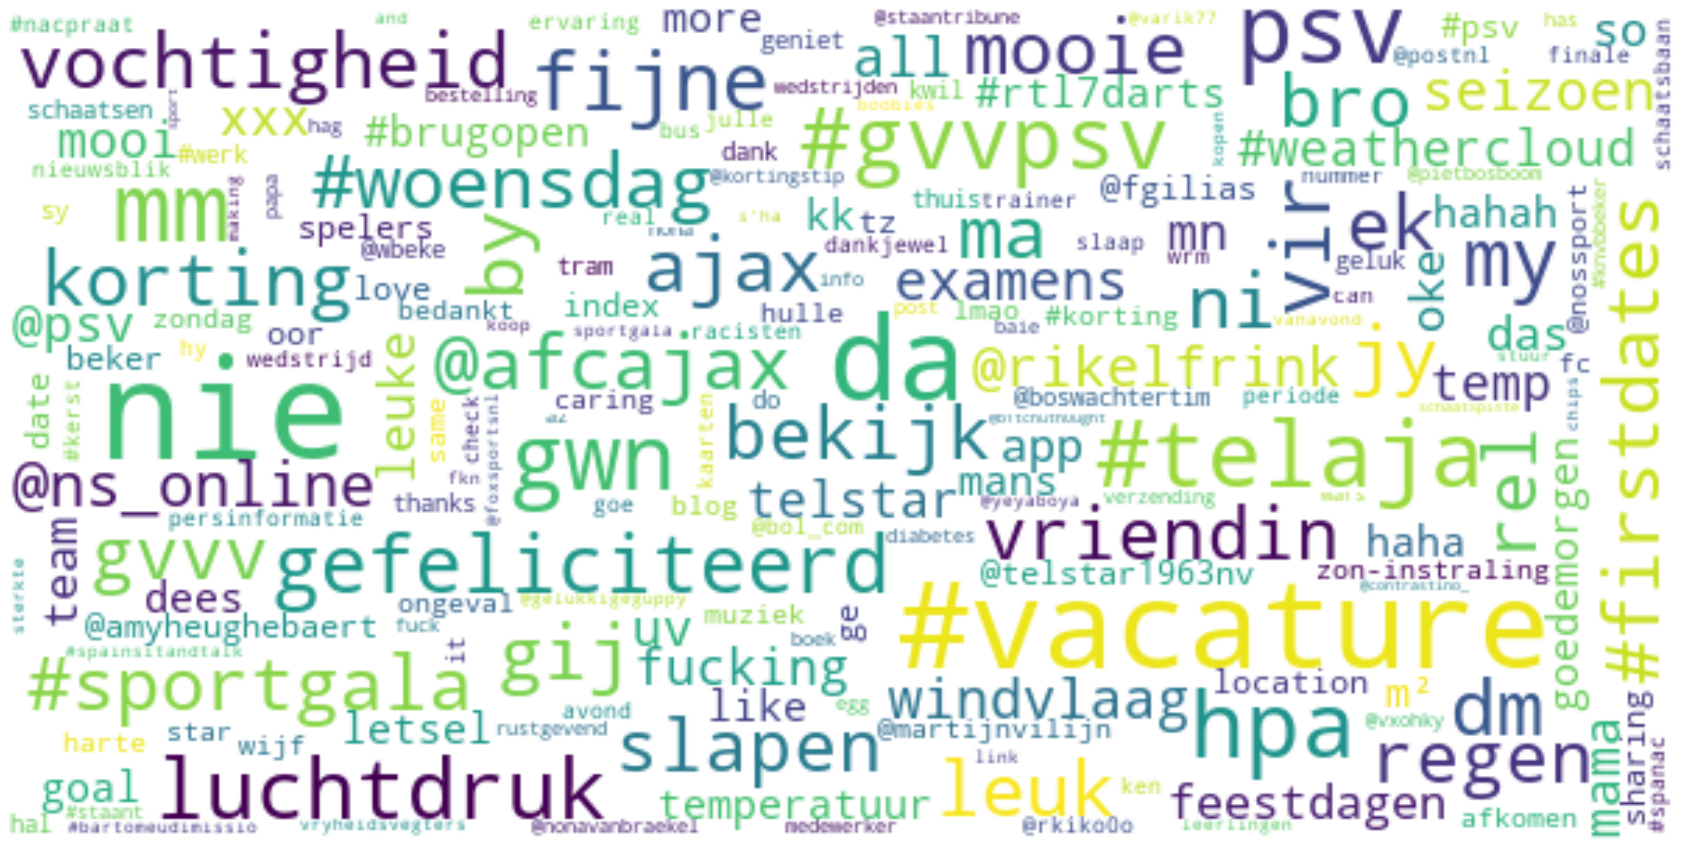

In [52]:
show_wordcloud(wordcloud.generate_from_frequencies(dict(tscores[:NBR_OF_TOKENS])))

## 5. Network analysis

In [98]:
import copy
import networkx as nx
import random

In [20]:
DATE = "20191218"

user_groups, largest_user_group, last_seen, user_pairs = process_day(DATE)

20191218-23.out.gz
date: 20191218; largest group size: 672; overlap with previous day: 0; tweets group: 78644; all tweets: 657230; member: sjonnie100


In [21]:
first_user = show_user_groups(user_groups, group_size_show=1)

672 ['058weestwel']
96 ['197winstonsmith']
8 ['ikbenoranjefan']


In [97]:
edges = {}
for user_pair in user_pairs:
    user1, user2 = user_pair.split()
    if user1 not in edges:
        edges[user1] = {}
    if user2 not in edges:
        edges[user2] = {}
    if user1 not in edges[user2]:
        edges[user2][user1] = user_pairs[user_pair]
    if user2 not in edges[user1]:
        edges[user1][user2] = user_pairs[user_pair]

In [109]:
CUTOFF = 5000

pruned_users = []
for user1 in edges:
    prune = True
    if len(edges[user1]) >= CUTOFF:
        prune = False
    else:
        for user2 in edges[user1]:
            if len(edges[user2]) >= CUTOFF:
                prune = False
                break
    if prune:
        pruned_users.append(user1)

pruned_edges = copy.deepcopy(edges)
for user1 in edges:
    if user1 in pruned_users:
        for user2 in edges[user1]:
            try:
                del(pruned_edges[user2][user1])
            except:
                pass
        del(pruned_edges[user1])

In [113]:
len(edges), len(pruned_edges)

(49236, 11017)

In [102]:
SELECTION_FACTOR = 1.0
selected_nodes = []
for user1 in pruned_edges:
    if random.random() < SELECTION_FACTOR:
        selected_nodes.append(user1)

In [111]:
G = nx.Graph()
largest_set_size = 0
for user1 in pruned_edges:
    if len(pruned_edges[user1]) > largest_set_size:
        largest_set_size = len(pruned_edges[user1])
    for user2 in pruned_edges[user1]:
        if user1 not in G:
            if user1 in user_groups[first_user]:
                G.add_node(user1, color="red")
            else:
                G.add_node(user1, color="blue")
        G.add_edge(user1, user2)

print(f"edges: {len(pruned_edges)}; selected: {len(selected_nodes)}; largest set size: {largest_set_size}")

edges: 11017; selected: 42288; largest set size: 6340


Requires downgrade of Matplotlib? `pip install matplotlib==2.2.3`

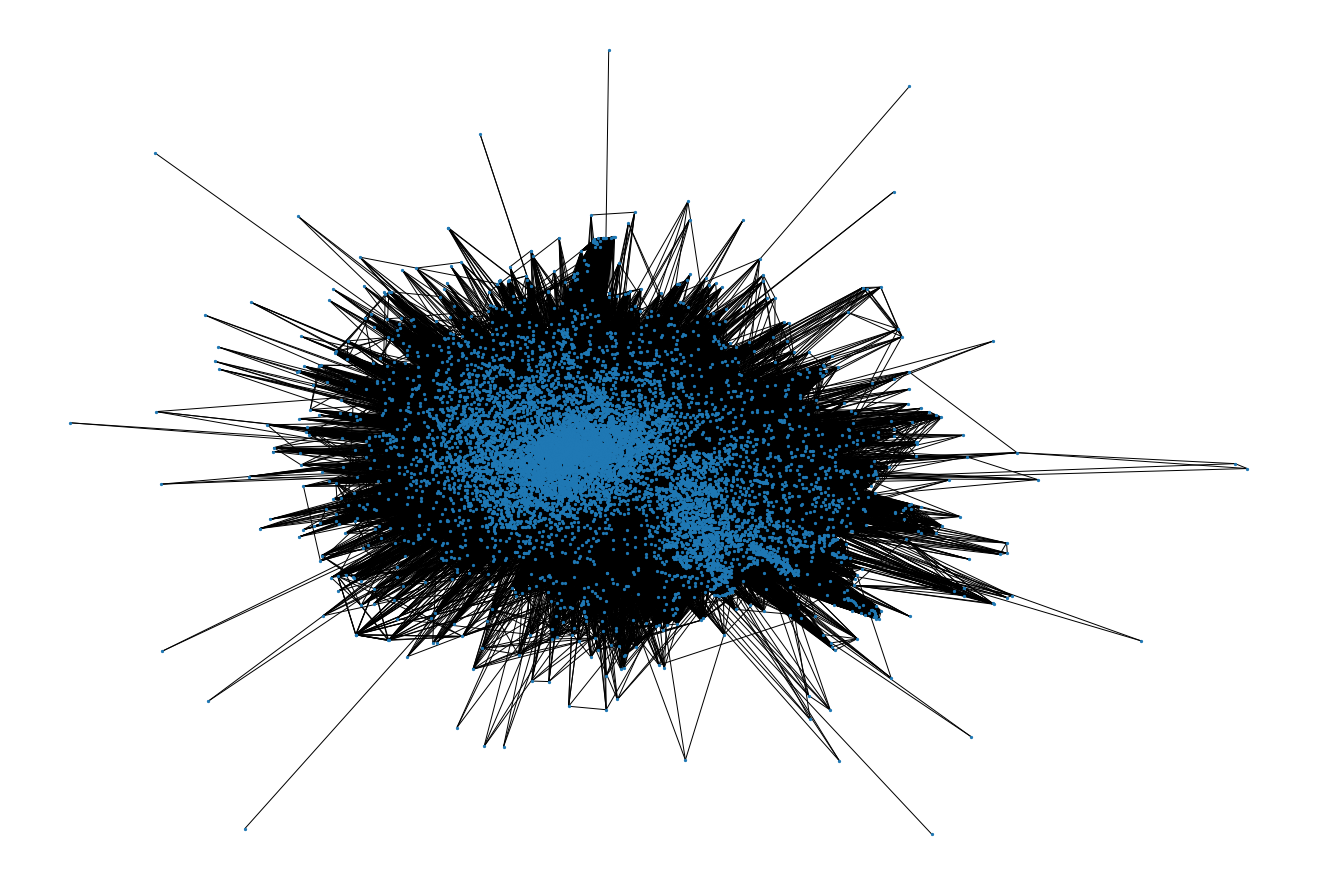

In [112]:
plt.figure(figsize=(18, 12))
nx.draw(G, with_labels=False, font_size=6, width=1, node_size=5)

## 6. Processing several dates

In [ ]:
previous_largest_user_group = []
last_seen = {}
for month in range(202112, 202201):
    for day in range(1, 32):
        date = str(month)+str(day).zfill(2)
        user_groups, previous_largest_user_group, last_seen, user_pairs = process_day(date, previous_largest_user_group, last_seen)

## 7. Visualizing multiple dates

In [ ]:
import pandas as pd 
import datetime
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
DATEFORMAT = "%Y%m%d"

In [ ]:
df = pd.read_csv(LOGFILE, index_col="date")

In [ ]:
PLOTFILENAME = "echo-chambers.png"

plt.subplots(figsize=(10,4))
plt.plot_date([datetime.datetime.strptime(str(d),DATEFORMAT) for d in df.index],
              [100*df.iloc[d]["group_tweets"]/df.iloc[d]["all_tweets"] for d in range(0,len(df))],
              xdate=True,fmt="-")
plt.title("Percentage of tweets per day from largest echo team on Dutch Twitter")
plt.savefig(PLOTFILENAME)
plt.show()